# ACS2 in Maze Experiments
The following notebooks provides reproducible playground for experimenting how ACS2 agent behaves inside Maze environments.
## Imports and configuration
Load project files from upper directory (nasty solution).

In [1]:
import sys
sys.path.append('/Users/khozzy/Projects/pyalcs')

Import `pyalcs` module

In [2]:
# Enable automatic module reload
%load_ext autoreload
%autoreload 2

from alcs.agent.acs2 import ACS2
from alcs.environment.maze import Maze

Other helpers

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd

# Visualization
from examples.helpers.visualization import plot_performance

## Experiment
We are going to test ACS2 **agent** inside **maze** environment.

### Agent
Agent moves in maze for the certain number of steps.

> **Trial** is a successful run of agent when he manages to find the reward.

> After learning it should take him less and less steps to reach the goal.

At the beginning of each trial an agent is randomly placed inside the maze. He can perceive 4 values (neighbourhood cells - N, E, S, W) and move in 4 directions (N, E, S, W).

### Maze
Let's specify which maze we want to use

In [4]:
# Location of the maze file
MAZE_LOCATION = 'mazes/MazeF1.maze'

And visualize it

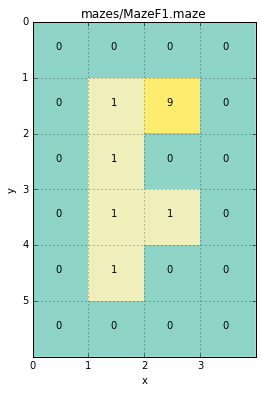

In [5]:
env = Maze(MAZE_LOCATION)

fig = plt.figure(figsize=(env.max_x, env.max_y))
ax = fig.add_subplot(111, aspect='equal')

# Render maze as image
plt.imshow(env.matrix, interpolation='none', cmap='Set3', aspect='auto',
           extent=[0, env.max_x, env.max_y, 0])

# Add labels to each cell
for x in range(0, env.max_x):
    for y in range(0, env.max_y):
        plt.text(x+0.4, y+0.5, env.matrix[y][x])

ax.set_title(MAZE_LOCATION)
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.xlim(0, env.max_x)
plt.ylim(env.max_y, 0)

plt.xticks(range(0, env.max_x))
plt.yticks(range(0, env.max_y))

plt.grid(True)
plt.show()

**Legend**:
- `0` is a $wall$ (cannot cross),
- `1` is a $path$ (reward $\rho = 0$),
- `9` is a $price$ (reward $\rho = 1000$)

### Run the simulation
The whole simulation will run a certain number of times for certain number of steps.

In [6]:
# Number of experiments
EXPERIMENTS = 25

# Number of agent steps for each experiment
STEPS = 500 # 10 000

After all the object `performance` will hold performance metrics useful for visualization.

In [7]:
performance = pd.DataFrame()

for experiment in range(EXPERIMENTS):
    
    # Initialize the environment
    env = Maze(MAZE_LOCATION)

    # Initialize the agent
    agent = ACS2(env)
    
    # Evaluate classifier
    classifiers, metrics = agent.evaluate(STEPS)
    
    # Add information about the experiment into metrics
    metrics['experiment_id'] = [experiment] * len(metrics['time'])
    
    # Append performance metrics
    performance = performance.append(pd.DataFrame(metrics))

We can also inspect how the classifier population looks.

In [8]:
print("Population consists of {} classifiers\n".format(len(classifiers)))
reliable = [c for c in classifiers if c.q > 0.9]

for cls in reliable:
    print(cls)

Population consists of 131 classifiers

Classifier{1011-2-0100 q:1.00, r:704.21}
Classifier{0100-0-1011 q:1.00, r:781.25}
Classifier{#01#-0-#### q:1.00, r:1668.57}
Classifier{##11-3-##00 q:1.00, r:999.88}
Classifier{#0##-0-#### q:0.99, r:1663.24}
Classifier{10##-0-#### q:1.00, r:509.76}
Classifier{###1-0-#### q:1.00, r:452.02}
Classifier{##11-0-#### q:1.00, r:452.02}
Classifier{###1-1-###0 q:1.00, r:638.00}
Classifier{##1#-0-#### q:1.00, r:1668.57}
Classifier{##19-0-#### q:0.98, r:1507.51}
Classifier{###9-0-#### q:1.00, r:1507.51}
Classifier{##19-0-#### q:0.97, r:1507.51}
Classifier{#019-2-#100 q:1.00, r:4319.64}
Classifier{#1##-1-#### q:1.00, r:466.37}
Classifier{01##-1-#### q:1.00, r:466.37}
Classifier{1000-2-#### q:1.00, r:874.99}
Classifier{##00-1-##11 q:0.99, r:924.82}
Classifier{1010-2-#### q:0.97, r:712.41}
Classifier{1000-3-#### q:1.00, r:772.82}
Classifier{0100-3-#### q:1.00, r:408.89}
Classifier{0100-2-101# q:0.90, r:2592.64}
Classifier{###1-0-1011 q:1.00, r:551.89}
Classifie

<p style="color:red">**TODO**: There are duplicate classifiers!!!! Maybe subsumption does not works. Why low quality classifiers are not removed?</p>

## Performance metrics
Let's have a look how the performance metrics look like by taking 5 random samples:

In [9]:
performance.sample(5)

,average_fitness,experiment_id,found_reward,time,total_classifiers
239,710.809721,9,False,240,84
100,181.121522,20,False,101,50
373,235.181085,23,False,374,107
344,248.342080,24,False,345,95
238,1019.310093,14,False,239,105


### Number of steps to food
Measures if the classifier actually *learns* something along the time.

> **Number of steps to food** - How many steps were needed in **each trial** to found the reward.

We need to have a little helper function for operating on obtained measurements.

In [10]:
def get_avg_number_of_steps_to_food(performance):
    trials_by_experiment = pd.DataFrame(performance
                                        .groupby('experiment_id')
                                        .apply(lambda x: x['found_reward'].cumsum())
                                        .stack())
    trials_by_experiment.reset_index(inplace=True)
    trials_by_experiment.rename(columns = {'found_reward': 'time', 0: 'trial'},
                                inplace=True)

    # Experiment_id, trial, steps
    steps_per_trial_in_experiment = pd.DataFrame(trials_by_experiment
                                                 .groupby(['experiment_id', 'trial'])
                                                 .size())
    steps_per_trial_in_experiment.reset_index(inplace=True)
    steps_per_trial_in_experiment.rename(columns = {0: 'steps'}, inplace=True)

    # Trial, averaged steps
    averaged_steps_per_trial = pd.DataFrame(steps_per_trial_in_experiment.groupby('trial')['steps'].mean())
    averaged_steps_per_trial.rename(columns = {'steps': 'averaged_steps'}, inplace=True)
    averaged_steps_per_trial.reset_index(inplace=True)
    
    return averaged_steps_per_trial

Now we can visualize the results

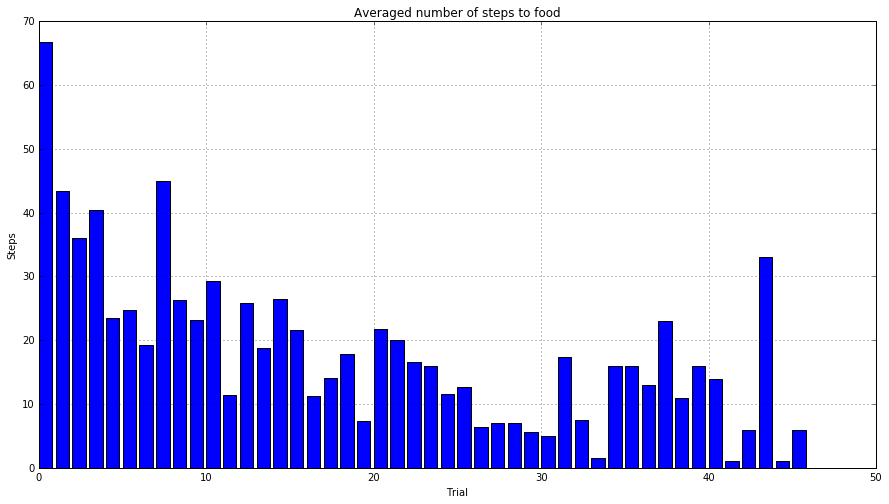

In [11]:
steps_to_food = get_avg_number_of_steps_to_food(performance)

fig = plt.figure(figsize=(15, 8), dpi=100)

plt.bar(steps_to_food['trial'], steps_to_food['averaged_steps'])
plt.title('Averaged number of steps to food')
plt.xlabel('Trial')
plt.ylabel('Steps')

plt.grid(True)

plt.show()

### Achieved knowledge

### Specificity measure
Measure the *generalization* in classifier population.

> **Specificity measure** - Equal to the **sum** of all specialized attributed in condition part of all classifiers in population **divided** by the number of classifiers **times** the length of  the perception $\sigma$.

You can read more about this metric in "*Introducing a Genetic Generalization Pressure to the
Anticipatory Classfierier System - Part2: Performance Analysis*" by Martin V. Butz.

Plot should change after modifing the agent's *mutation* and *cross over* values. The author claims that the best generalization was reached for mutation rate $\mu = 0.4$.

<hr />
The following image presents how the plot can look like:
![title](temp/generalization.png)

In [12]:
mat

NameError: name 'mat' is not defined